## Exercise 3: Reddit Data

The task comes with two parts:

- Determine the attributes of a successful post on r/askscience
- Build a model that can predict the score of a post on r/askscience given at least the title and body of the post (There is no need to limit it to just the title and body, but you must explain why you chose the features you did).

### 1. Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
reddit_df = pd.read_csv('askscience_data.csv',index_col= 0)
reddit_df

,title,body,tag,datetime,author,score,upvote_ratio,url
0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...
1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...
2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...
3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...
4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...
...,...,...,...,...,...,...,...,...
795,I heard some electron microscopes use gallium....,NaN,Engineering,2022-01-12 17:14:35,Emma_Dale20,6.0,0.70,https://www.reddit.com/r/askscience/comments/s...
796,is the spread of COVID typical for a respirato...,i understand that there's no respiratory virus...,COVID-19,2022-01-12 09:39:55,aggasalk,27.0,0.74,https://www.reddit.com/r/askscience/comments/s...
797,What is the technical difference between Cheek...,What are the technical difference(s) between t...,COVID-19,2022-01-12 14:47:28,h110hawk,3.0,0.67,https://www.reddit.com/r/askscience/comments/s...
798,What starts the coagulation cascade during blo...,I understand that stasis of blood increases th...,Human Body,2022-01-12 14:20:26,joegoldbergg,5.0,0.78,https://www.reddit.com/r/askscience/comments/s...


In [3]:
reddit_df['datetime'].min()

'2010-10-29 12:18:12'

In [4]:
reddit_df['datetime'].max()

'2022-12-09 13:06:01'

The attribute `score` in Raddit refers to the net number of upvotes minus downvotes that a post or comment has received. The score represents the overall popularity or perceived quality of the post or comment within the Reddit community. The attribute `upvote_ratio` refers to # upvote/# all_votes. Both of them are the attributes of a successful post. A high level of score means and high upvote means a lot of people viewed this post and majority of them think it is helpful. Blow is the distributions of `log2(score+1)` and `upvote_ratio`, which are bimodel. And there's positive correlation between these two variables.

Text(0.5, 1.0, 'Histogram of log2(score+1) across all the data')

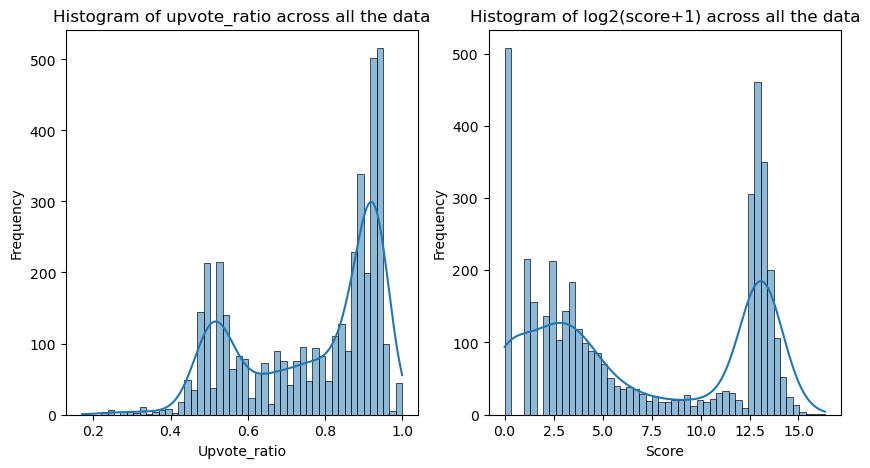

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(reddit_df['upvote_ratio'], bins=50, kde=True,  edgecolor='black',ax=axes[0])  
axes[0].set_xlabel('Upvote_ratio')  
axes[0].set_ylabel('Frequency')  
axes[0].set_title('Histogram of upvote_ratio across all the data') 

sns.histplot(np.log2(reddit_df['score']+1), bins=50, kde=True,  edgecolor='black',ax=axes[1])  
axes[1].set_xlabel('Score')  
axes[1].set_ylabel('Frequency')  
axes[1].set_title('Histogram of log2(score+1) across all the data') 



Text(0, 0.5, 'Score')

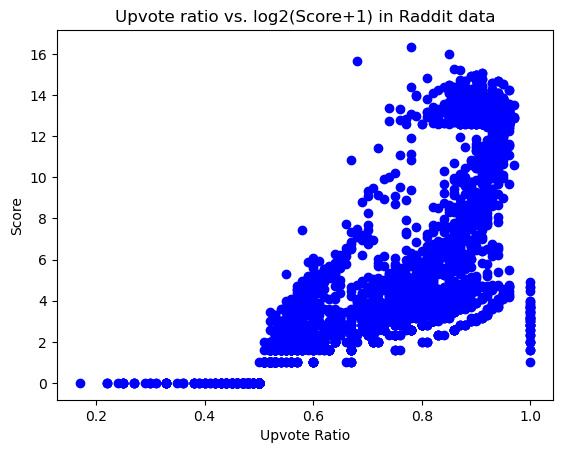

In [6]:
plt.scatter(reddit_df['upvote_ratio'], np.log2(reddit_df['score']+1), color='blue')  
plt.title('Upvote ratio vs. log2(Score+1) in Raddit data')  
plt.xlabel('Upvote Ratio')  
plt.ylabel('Score') 

### 2. Build a machine learning model to predict a score for a Raddit post given the title and body

**Summary of this session:**<br><br>
The mse and mae in the test data are very high, which indicates the model is not a good fit. There are a few possible reasons:

- The random forest is not a good model to estimate the relationship between Raddit score and title+body. We can use deep learning models using tensorflow or XGBoost model instead to fit the data.
- Using title and body only cannot predict Raddit score acccurately. We can induce more variables, such as tag, hour,is_weekend,upvote_ratio, since they are associated with score.

In [7]:
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten

import xgboost as xgb

[nltk_data] Downloading package punkt to /Users/jiongchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiongchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jiongchen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


There are 1713 `bodies` with `NaN`, which is a large fraction of the data. Need to look into this.

In [8]:
reddit_df['body'].isna().sum() #1713
#reddit_df['title'].isna().sum() #0
#reddit_df['score'].isna().sum() #0

1713

In [9]:
reddit_df.loc[reddit_df['body'].isna(),'title'].iloc[0]

'Are there cells in humans (or other mammals) that are "immune" to cancer?'

I manually checked several of these posts with `NaN` in the `body` column. Looks like these posters didnot input anything in the `body`. So I impute the `NaN` with `No body text`.

In [10]:
reddit_df['body'].fillna('No body text', inplace=True)

The code below prepross the text data in `bodies` and `titles`.

In [11]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and punctuation, and lemmatize tokens
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
    
    return ' '.join(filtered_tokens)

# Apply preprocessing to 'title' and 'body' columns
reddit_df['clean_title'] = reddit_df['title'].apply(preprocess_text)
reddit_df['clean_body'] = reddit_df['body'].apply(preprocess_text)

In [12]:
from datetime import datetime
reddit_df['datetime_obj'] = pd.to_datetime(reddit_df['datetime'], format='%Y-%m-%d %H:%M:%S')
reddit_df['hour'] = reddit_df['datetime_obj'].dt.hour
reddit_df['weekday'] = reddit_df['datetime_obj'].dt.weekday
reddit_df['is_weekend'] = reddit_df['weekday'].isin([5, 6]) 

In [13]:
#reddit_df['tag'].value_counts()

I included `clean_title`, `clean_body` in the training data. In the future, I can also include `tag`, `hour`,`is_weekend`,`upvote_ratio` in the training data as well, since they are associated with `score`.

In [14]:
X = reddit_df[['clean_title', 'clean_body']]
y = reddit_df['score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)


In [15]:
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  
    ('regressor', RandomForestRegressor())  
])


text_pipeline.fit(X_train['clean_title'] + ' ' + X_train['clean_body'] , y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('regressor', RandomForestRegressor())])

The mse and mae in the test data are very high, which indicates the model is not a good fit. There are a few possible reasons:
- the random forest is not a good model to estimate the relationship between Raddit score and title+body. We can use deep learning models or GBM model instead to fit the data.
- Using title and body only cannot predict Raddit score acccurately. We can induce more variables, such as `tag`, `hour`,`is_weekend`,`upvote_ratio`, since they are associated with `score`.

In [16]:
y_pred = text_pipeline.predict(X_test['clean_title'] + ' ' + X_test['clean_body'])

# Calculate evaluation metrics (e.g., mean squared error)
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 3030.6011983749654
